In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yaml
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
from tools import PDFs
import matplotlib.pyplot as plt
import numpy as npA
import lhapdf
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [47]:
class Data : 
    def __init__(self, dtlist, norm, penalty) : 
        self.norm = norm 
        self.penalty = penalty 
        pt = dtlist[0]
        self.ID = pt["IDDataSet"]
        self.typeExp = pt["TypeExp"]#
        self.A1 = pt["A1"]
        self.A2 = pt["A2"]
        self.Z1 = pt["Z1"]
        self.Z2 = pt["A1"]
        self.kinvarname = list(pt["KinVarVals"].keys() )
        self.table = self._createDF(dtlist)
        self.chi2nopen = np.sum(self.table["Chi2"])
        self.chi2 = self.chi2nopen+ penalty
        self.N = len(dtlist)
        self.chi2dof = self.chi2/self.N
        #display(self.table)

    def _createDF (self, dt) : 
        mat = []
        for p in dt : 
            kinvar = list(p["KinVarVals"].values())
            row = kinvar + [p["Data"], p["Theo"], p["Chi2"]]
            mat.append(row.copy())
        return pd.DataFrame(mat, columns= self.kinvarname+ ["Data", "Theory", "Chi2"] )



class DataSets : 
    def __init__(self, file) : 
        ostream = open(file)
        self.yout = yaml.safe_load(ostream)
        self.Ntot =0
        self._getListData()
        
    
    def _getListData (self) : 
        pts = self.yout["Chi2Fcn"]["Snapshots"][0]["perPointBreakdown"]
        self.Ntot = len(pts)
        data = []
        dt = []
        ID = int(pts[0]["IDDataSet"]) 
        self.IDlist = [ID]
        penPerID = {ID: 0.0}
        normPerID = {ID:1.0}
        for i, pt in enumerate(pts) : 
            if (int(pt["IDDataSet"]) != ID or i==(self.Ntot-1) ) : 
                data.append(dt.copy())
                dt = []
                ID = int(pt["IDDataSet"])
                self.IDlist.append(ID)
                penPerID[ID] = 0.0
                normPerID[ID] = 1.0
            dt.append(pt) 
        normStats = {}
        pts = self.yout["Chi2Fcn"]["NormInfo"]
        for p in pts : 
            p_ids = list(p["IDs"])
            N_ids = len(p_ids)
            pen_perid = p["Penalty"]/N_ids 
            norm_ids = p["Value"]
            for id in p_ids : 
                penPerID[id] = pen_perid
                normPerID[id] = norm_ids

        self.datasets = {}
        for id, d in zip(self.IDlist, data) : 
            self.datasets[id] = Data (d, normPerID[id], penPerID[id])

        chi2tot =0.0
        chi2wopen =0.0
        for id, d in self.datasets.items() : 
            chi2tot = chi2tot + d.chi2 
            chi2wopen = chi2wopen+ d.chi2nopen 

        print("Chi2 total : ", chi2tot)
        print("Chi2 w/o penalty : ", chi2wopen)
        self.chi2dof =  chi2tot/self.Ntot

    def filterByExp (self, exp) : 
        dlist = []
        N = 0.0
        chi2 =0.0
        for id, d in self.datasets.items() : 
            if d.typeExp == exp : 
                dlist.append(d)
                N = N+ d.N 
                chi2 = chi2 + d.chi2 

        return [dlist, N, chi2, chi2/N]

Chi2 total :  2705.612396345595
Chi2 w/o penalty :  2674.209907557779


<Figure size 1440x288 with 0 Axes>

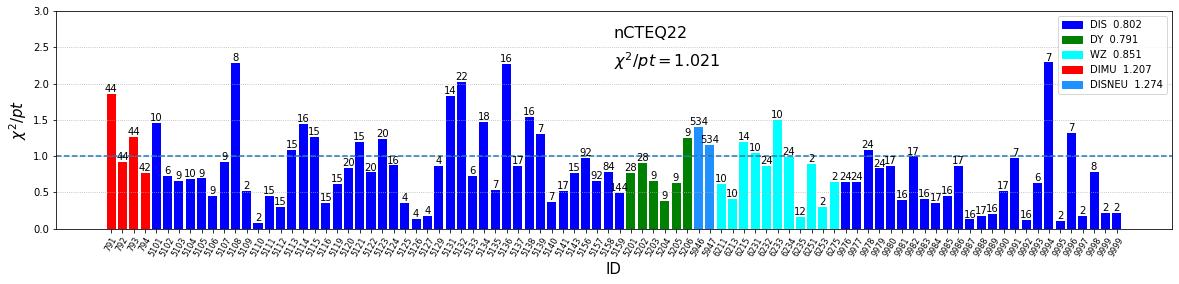

In [46]:
dt = DataSets("lhapdfs.yaml")
fitname ="nCTEQ22"
idList = dt.IDlist
idList.sort()
index = np.arange(len(idList))
chi2dof_perid =[]
N_perid = []
colors = []
for id in idList : 
    d = dt.datasets[id] 
    chi2dof_perid.append(d.chi2dof)
    N_perid.append(d.N)
    if id in [791, 792, 793, 794]:
        colors.append("red") #DIMU
    elif id <= 4999 and id >=4000 :
        colors.append("yellow")#SIH
    elif (id <5200 and id >=5000) or (id <=10000  and id>=9900) :
        colors.append("blue")#DIS
    elif id <5300 and id >=5200 :
        colors.append("green")#DY
    elif id <5999 and id>=5900 :
        colors.append("dodgerblue")#DISNEU
    elif id>=6000:
        colors.append("cyan")#WZ
    else : 
        pass



labelColors = ["blue","green", "cyan", "red",  "dodgerblue"]
#labelColors = ["blue","green", "yellow", "cyan"]
labels = ["DIS  " +str(round( dt.filterByExp("DIS")[3], 3)),
            "DY  "+str(round(dt.filterByExp("DY")[3],3)), 
            #"SIH " +str(round(dt.filterByExp("SIH")[3], 3)),
            "WZ  " +str(round(dt.filterByExp("WZPROD")[3], 3)),
             "DIMU  " +str(round(dt.filterByExp("DISDIMU")[3], 3)),
             "DISNEU  "+str(round(dt.filterByExp("DISNEU")[3], 3)),
            ]

        
handles = [plt.Rectangle((0,0),1,1, color=labelColors[i]) for i in range(len(labelColors))]
plt.figure(figsize=(20,4))
fig, ax = plt.subplots(figsize=(20,4))
ax.axhline(1.0, linestyle="dashed")
barPlot = ax.bar(index, chi2dof_perid, color = colors)

for num, rect in zip(N_perid, barPlot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, num, ha='center', va='bottom',  fontsize=10)
    
# add information on fitname
plt.gca().text(0.5, 0.93, fitname , transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
# add information on total chi2/dof
plt.gca().text(0.5, 0.82, "$\chi^2/pt={}$".format(round(dt.chi2dof, 3)), transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
plt.xlabel("ID", fontsize=15)
plt.ylabel('$\chi^2/pt$', fontsize=15)
plt.xticks(index, idList, fontsize=8, rotation=60)
#plt.title('Chi2/dof per dataset', fontsize=15 )
plt.legend(handles, labels)
plt.grid(True, axis="y", zorder=0, linestyle="dotted")
plt.ylim(0,3.0)

plt.savefig('chi2dof_'+fitname+'.pdf', bbox_inches='tight')
plt.show()